# Deep Hedging Model

Deep Hedging descibes the way to use a Deep Learning approach to optimize hediging strategies in financial markets. In this script we will focus on approximating the optimal hedging strategy for a European style option.

## Black Scholes equation
First we make the following introduction to the Black-Scholes equation. The Black-Scholes equation is a fundamental mathematical model for pricing financial derivatives, particularly options. It describes the dynamics of an asset's price $S_t$​ under the assumption that the asset follows a geometric Brownian motion. The Black-Scholes stochastic differential equation (SDE) is given by:

$$ dSt=rSt dt+σSt dWt $$
where:
- $S_t$​: Asset price at time $t$
- $r$: Risk-free interest rate,
- $\sigma$: Volatility of the asset,
- $W_t$: Brownian motion.

## Solution to Black-Scholes
We check that $ S_t = S_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE for $r=0$.

Let us define $h$ to be the function such that 

$$h(t,W_t)=s_0\exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$$

Note that Itô's Lemma implies
$$dS_t = \frac{\partial h}{\partial W_t}dW_t +\Bigl( \frac{\partial h}{\partial t} +\frac{1}{2}\frac{\partial^2 h}{\partial W_t^2}\Bigl)dt.$$

Calculating the partial derivatives yields
$$\frac{\partial h}{\partial W_t} = \sigma S_t$$
$$\frac{\partial^2 h}{\partial W_t} = \sigma^2 S_t$$
$$\frac{\partial h}{\partial t} = -\frac{1}{2}\sigma^2S_t. $$

Thus, plugging this into Ito's formula implies

$$dS_t = \sigma S_t dW_t + (-\frac{1}{2}\sigma^2 + \frac{1}{2}\sigma^2)dt =  \sigma S_t dW_t.$$

Hence, $S_t$ solves the Black-Scholes equation for $r=0$.



## Dataset generation 
We generate at dataset following the solution of the Black-Scholes SDE.

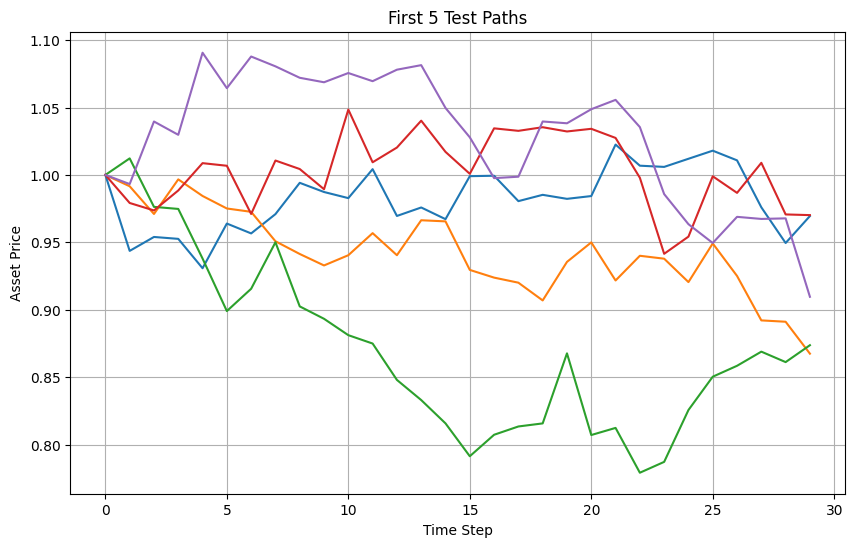

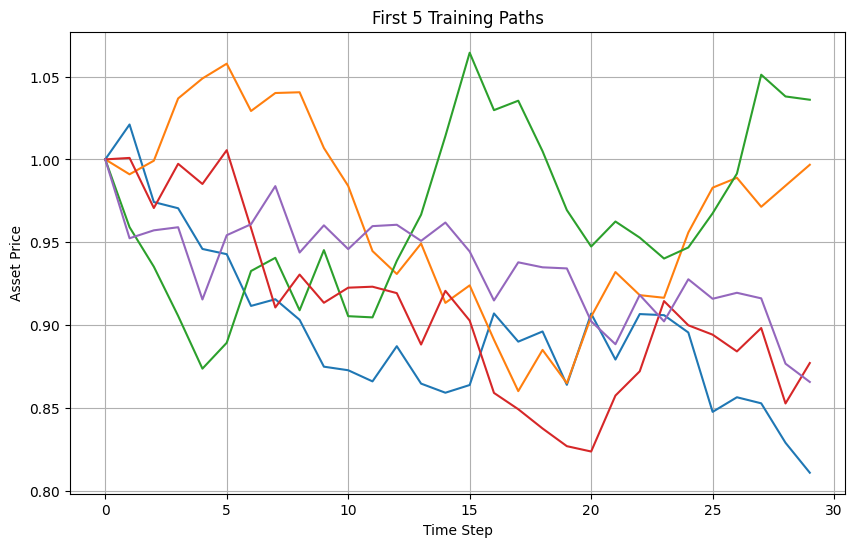

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 30               # Number of time steps
n_training = int(1e6) 
n_test = int(1e5)   
S_t0 = 1             # Initial asset price
T = 30 / 365         # Time to maturity in years
sigma = 0.5          # Volatility

dt = T / N
drift = -0.5 * sigma**2 * dt
diffusion = sigma * np.sqrt(dt)

def generate_paths(n_paths, N, S_t0, drift, diffusion):
    """
    Generates data

    Inputs:
    - n_paths: Number of paths to generate
    - N: Number of time steps
    - S_t0: Initial asset price
    - drift: Drift component of the GBM
    - diffusion: Diffusion component of the GBM

    Returns:
    - S: (n_paths, N+1) vector containing data
    """
    # Generate (n_paths, N) matrix of standard normal random numbers
    Z = np.random.randn(n_paths, N-1)
    factors = np.exp(drift + diffusion * Z)
    S = S_t0 * np.cumprod(factors, axis=1)
    S = np.concatenate((np.full((n_paths, 1), S_t0), S), axis=1)
    
    return S

# Generate test and training paths
S_test = generate_paths(n_test, N, S_t0, drift, diffusion)
S_train = generate_paths(n_training, N, S_t0, drift, diffusion)

# Plot the first 5 test paths
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(S_test[i, :])
plt.title('First 5 Test Paths')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

# Plot the first 5 training paths
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(S_train[i, :])
plt.title('First 5 Training Paths')
plt.xlabel('Time Step')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()


## Definition of the Deep Heding Model

Below we will analyse $N-1= 29$ neural networks with two hidden layers with $32$ and $64$ neurons respectively and the ReLu activation function. As an input the $i-$ th networks takes in $\log(S_{t_i})$ and gives as an output the optimal number of units to hold at time $t_i$.

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(0) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {"GPU" if torch.cuda.is_available() else "CPU"}')

# Hyperparameter
n_neurons = 32

# Create a single model 
class DeepHedging(nn.Module):
    def __init__(self, N, n_neurons):
        super(DeepHedging, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2*n_neurons),
            nn.ReLU(),
            nn.Linear(2*n_neurons, 1)
        )
    
    def forward(self, x):
        x = torch.log(x)  
        return self.network(x).view(-1)


class DeepHedgingModel(nn.Module):
    """
    Container holding (N-1) DeepHedgingModel networks.
    Each sub-network has the same architecture as DeepHedgingModel.
    """
    def __init__(self, N, n_neurons):
        super(DeepHedgingModel, self).__init__()
        self.models = nn.ModuleList([
            DeepHedging(N, n_neurons) for _ in range(N - 1)
        ])

    def forward(self, x):
        outputs = []
        for i, net in enumerate(self.models):
            xi = x[:, i].unsqueeze(1)
            out = net(xi)
            outputs.append(out)
        
        return torch.stack(outputs, dim=1)
    
model = DeepHedgingModel(N, n_neurons).to(device)

Using CPU


## Backround Information

We consider selling a European call option with payoff
$$g(S_T) := (S_T - K)^+.$$
where we set strike price $K = 1$.

Note that under the Black-Scholes model the value of a European call option at time $t$ is given by
$$C(S_t,t) = \Phi(d_+)S_t - K\Phi(d_-)\exp(-r(T-t))$$ 
where $\Phi$ is the Gaussian CDF and
 $$d_+ = \frac{1}{\sigma\sqrt(T-t)}\Bigl(\log(S_t/K)+(r+\sigma^2/2)(T-t)\Bigl)$$
 and $d_- = d_+-\sigma\sqrt{T-t}$.


In [3]:
# parameters
K = 1 # Strike price

def payoff(S_t, K):
    """ Payoff function of a European call option 
    Inputs: - S_t: Price of the underlying asset at time t
            - K: Strike price
    Output: Payoff of the option
    """
    return torch.maximum(S_t - K, torch.tensor(0.0, device=S_t.device))


def standard_Gaussian_cdf(x):
    """ CDF of the standard normal distribution
    Input: x: Value at which to evaluate the CDF
    Output: CDF(x)
"""
    return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0, device=x.device))))

def BS_price(S_t,t, K, T, sigma,r):
    """ Price of a European call option under the Black-Scholes model
    Inputs: - S_t: Price of the underlying asset at time t
            - t: Current time
            - K: Strike price
            - T: Time to maturity
            - sigma: Volatility
            - r: Risk-free interest rate
            Output: Price of the option"""
    tau = torch.tensor(T - t, device=S_t.device)
    sqrt_Tt = torch.sqrt(tau)
    d_plus = (torch.log(S_t / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * sqrt_Tt)
    d_minus = d_plus - sigma * sqrt_Tt
    return S_t * standard_Gaussian_cdf(d_plus) - K * standard_Gaussian_cdf(d_minus) * torch.exp(-r * tau)

# More backround information

In the Black–Scholes framework, every option can be hedged. This hedging strategy is determined by solving the following optimization problem:
$$
\inf_{H \in \mathcal{H}} \mathbb{E} \left[ \left( g(S_T) - p - \int_0^T H_u \, dS_u \right)^2 \right],
$$

where:
- $\mathcal{H}$ denotes the set of all predictable processes.
- $p$ is the risk-neutral price of the option.

We discretize the time interval using a uniform grid:

$0 = t_0 < t_1 < \cdots < t_N = T$

and approximate the Itô integral by the discrete stochastic sum:

$$\sum_{j=0}^{N-1} H_{t_j} \cdot \left(S_{t_{j+1}} - S_{t_j} \right),$$

where $ H_{t_0}, \dots, H_{t_{N-1}}$ the above defined $N$ neural networks. Hence we aim to train them jointly for the following empirical loss

$$
\frac{1}{m} \sum_{i=1}^m \left( g \left(S_T^{(i)}\right) - p - \sum_{j=0}^{N-1} H_{t_j} \cdot \left(S_{t_{j+1}}^{(i)} - S_{t_j}^{(i)} \right) \right)^2.
$$

In [4]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

X_train = torch.tensor(S_train, dtype=torch.float32).to(device)
y_train = payoff(X_train[:, -1],K).to(device)
train_dataset = TensorDataset(X_train, y_train)
#Hyperparameters for training
batch_size = 1000
n_epochs = 100
learning_rate = 1e-4

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min',factor=0.1, patience=10, min_lr= learning_rate/1000)
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = torch.nn.MSELoss()

100%|██████████| 100/100 [35:17<00:00, 21.17s/it, loss=8.25e-5]


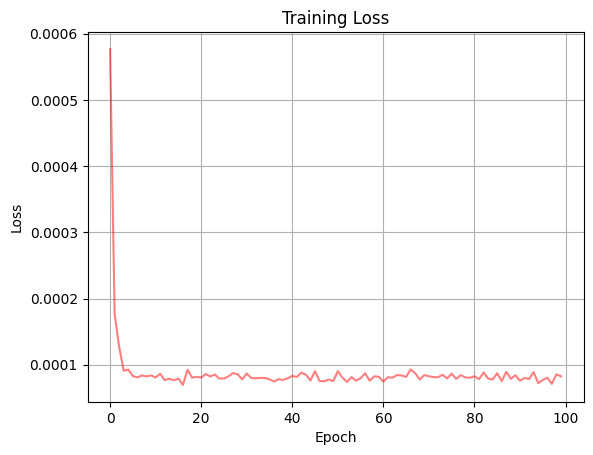

In [5]:
losses = []
model.train()
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
    
        networks = model(X_batch[:, 0:N-1])
        delta_S = X_batch[:, 1:N] - X_batch[:, 0:N-1] 

        pred = torch.sum(networks * delta_S, dim=1)
        temp = BS_price(X_batch[:, 0], 0, 1, 30/365, 0.5, 0).to(device) # constant since S_t0 = 1

        pred += temp

        # Compute the loss
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()     

    training_loop.set_postfix(loss = loss.item())
    scheduler.step(loss)
    losses.append(loss.item())

plt.plot(losses, label='Training loss', color='red', alpha=0.5)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model evaluation

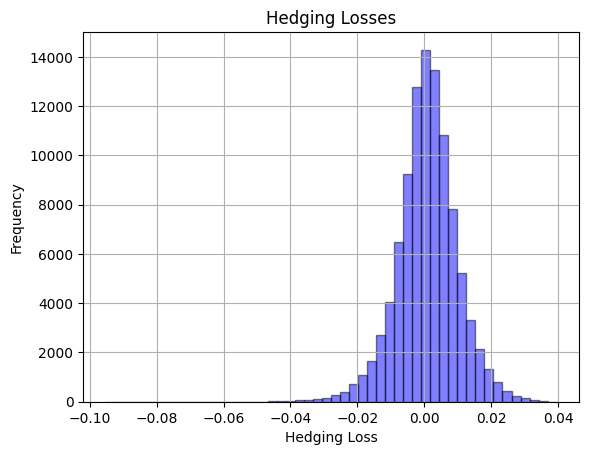

Mean hedging loss: 0.0009
Standard deviation of hedging loss: 0.0090


In [6]:
X_test = torch.tensor(S_test, dtype=torch.float32).to(device)
y_test = payoff(X_test[:, -1],K).to(device)
test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
hedging_losses = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        networks = model(X_batch[:, 0:N-1])
        delta_S = X_batch[:, 1:N] - X_batch[:, 0:N-1]
        pred = torch.sum(networks * delta_S, dim=1)
        temp = BS_price(X_batch[:, 0], 0, 1, 30/365, 0.5, 0).to(device)
        pred += temp
        loss = pred-y_batch
        hedging_losses.append(loss.item())
        
# Plot a histogram of the hedging losses and print mean and standard deviation
hedging_losses = np.array(hedging_losses)
plt.hist(hedging_losses, bins=50, alpha=0.5, edgecolor='k', color= 'blue')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.title('Hedging Losses')
plt.grid(True)
plt.show()
mean_loss = np.mean(hedging_losses)
std_loss = np.std(hedging_losses)

print(f'Mean hedging loss: {mean_loss:.4f}')
print(f'Standard deviation of hedging loss: {std_loss:.4f}')

## Interpretation

Note that the mean hedging loss is centered around zero which means that the model does not over or under value the assets. Furthermore, the small standard deviation indicates consistency. One could improve this neural networks by playing around with different optimizers, scheduler, learning rates, archicetures, activation function, batch sizes, epochs.


# Analytical Solution

Since we are operating under the Black-Scholes model there is actually a analytical hedging strategy given by
\begin{align*}
H =\frac{\partial C(S_t,t)}{\partial S_t}
\end{align*}

Note that $\Phi'(x)= \phi(x)$ where $\phi(x)= \frac{1}{\sqrt{2\pi}}e^{-x^2/2}$ is the Gaussian pdf. Furthermore, note that $$ \partial_s d_+ = \partial_s d_- = \frac{2}{\sqrt{T-t}s}$$

Thus we see that,
\begin{align*}
H =\partial_s C(s,t)&= s\partial_{d_+}\Phi(d_+)\partial_sd_+ + \Phi(d_+)- \partial_{d_-}\Phi(d_-)\partial_sd_- 
= \frac{2\phi(d_+)}{\sqrt{T-t}}+ \Phi(d_+)-\frac{2\phi(d_-)}{s\sqrt{T-t}} = \Phi(d_+).
\end{align*}

Note that the last equality comes from the fact that 

\begin{align*}
    \phi(d_-) = \phi(d_+)\exp(d_+\sqrt{T-t}-1/8(T-t)) = \phi(d_+)\exp(\log(s))= s \phi(d_+)
\end{align*}

We will analyze how well this theoretically optimal solution performs on our data set.

In [18]:
def H_BS(t, S_t, T = 30/365):
    """returns the analytic solution of the hedging strategy
    Inputs: - t: current time
            - S_t: price of the underlying asset at time t
            - T: time to maturity
    Output: H:  analytical hedging strategy"""
    time_to_maturity = T-t
    sqrt_time = torch.sqrt(time_to_maturity)
    d_plus = 2 / sqrt_time * (torch.log(S_t) + 1/8 * time_to_maturity)
    H = standard_Gaussian_cdf(d_plus)
    return H

t = torch.linspace(0, 30/365, N+1).to(device)
delta_S = X_test[:, 1:N] - X_test[:, 0:N-1]
H = H_BS(t[0:N-1], X_test[:, 0:N-1])
analytic_hedging_losses = torch.sum(H * delta_S, dim=1) + BS_price(X_test[:, 0], 0, 1, 30/365, 0.5, 0) - payoff(X_test[:, -1], 1)

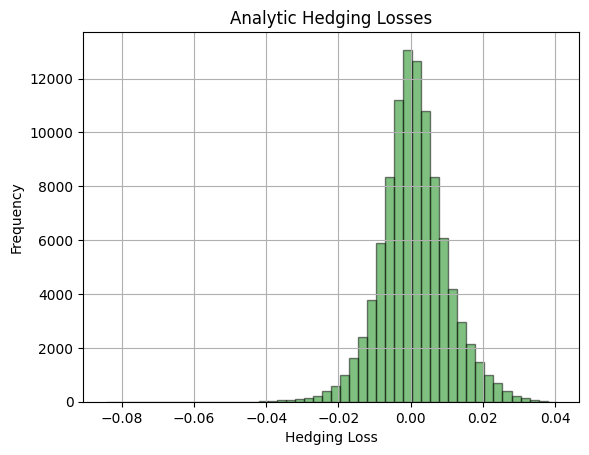

Mean Hedging Loss: 0.0009449544595554471
Standard Deviation of Hedging Loss: 0.00910485815256834


In [19]:
plt.hist(analytic_hedging_losses, bins=50, alpha=0.5, edgecolor='k', color= 'green')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.title('Analytic Hedging Losses')
plt.grid(True)
plt.show()

analytical_mean_loss = torch.mean(analytic_hedging_losses)
analytical_std_loss = torch.std(analytic_hedging_losses)
print(f'Mean Hedging Loss: {analytical_mean_loss}')
print(f'Standard Deviation of Hedging Loss: {analytical_std_loss}')

## Interpretation
Although we're using the analytical hedging strategy, losses aren't zero because the solution assumes continuous rebalancing while we rebalance at discrete intervals. Numerical instabilities may also contribute.

## Comparison of the Analytical solution and the neural net

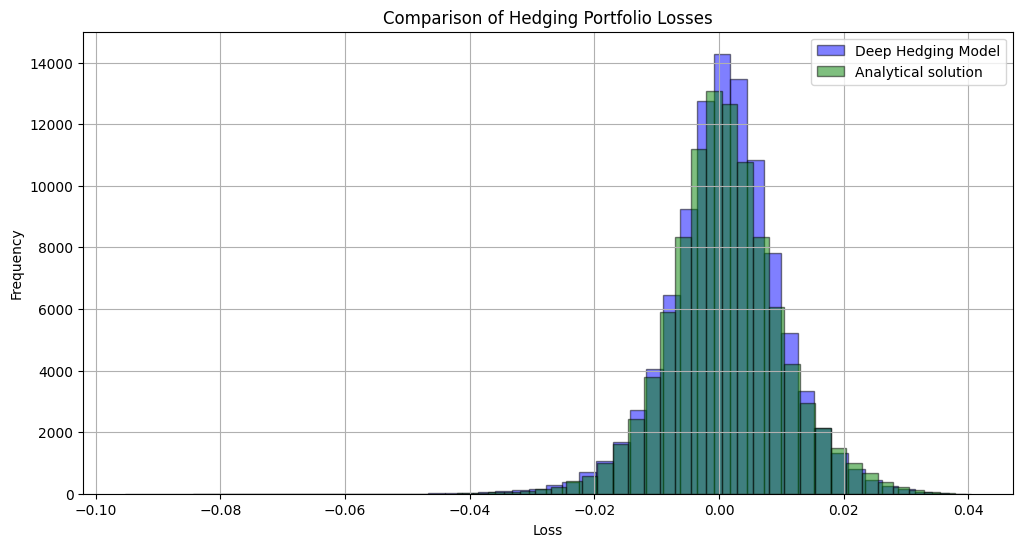

Deep Hedging Losses: Mean = 0.000945, Std Dev = 0.008963
Analytical Hedging Losses: Mean = 0.000945, Std Dev = 0.009105


In [20]:
plt.figure(figsize=(12, 6))

plt.hist(hedging_losses, bins=50, alpha=0.5, label='Deep Hedging Model', edgecolor='k', color='blue')

plt.hist(analytic_hedging_losses, bins=50, alpha=0.5, label='Analytical solution', edgecolor='k', color= 'green')

plt.title('Comparison of Hedging Portfolio Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

print(f"Deep Hedging Losses: Mean = {mean_loss:.6f}, Std Dev = {std_loss:.6f}")
print(f"Analytical Hedging Losses: Mean = {analytical_mean_loss:.6f}, Std Dev = {analytical_std_loss:.6f}")

## Interpretation
One can see that our model performs very similar to the analytical solution. The main difference is that one a real market the asset prices do not follow the Black-Scholes model and hence a analytical hedging strategy is not available but the neural net could be trained for these situations.

# Single Neural Network Model

We have seen in the above that a multiple neural nets jointly trained can approximate the analytical hedging strategy well. In the following we want to implement a Model introduced in Buehler, H., Gonon, L., Teichmann, J., & Wood, B. (2019). Deep hedging. Quantitative Finance, 19(8), 1271–1291. https://doi.org/10.1080/14697688.2019.1571683. It shows that we can reduce to a single neural net with less parameters with similar performance.

Precisely, we consider a fully connected neural net $F$ with with a single hidden layer with $32$ neurons and the ReLu activation function. It takes as an input $(\sqrt{T-t}, S_t)$ and calculates the predicted optimal amount of units held at time $t$.

Note, that this is also called Deep Hedging even though the neural network we consider is not deep.

In [13]:
n_neurons = 32
class DeepHedgingSingle(nn.Module):
    def __init__(self, n_neurons, T=30/365):
        """
        Defines a neural net with 2 input neurons and 1 output neuron ReLU activation functions two hidden layers with n_neurons neurons each
        Inputs: - n_neurons: Number of neurons for the first linear layer
                - T: Total time horizon so that we apply sqrt(T - t)
        """
        super(DeepHedgingSingle, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 1)
        )
        self.T = T

    def forward(self, t, x):
        t_trans = torch.sqrt(self.T - t)
        x_trans = torch.log(x)
        temp = torch.full((x.shape[0], 1), t_trans)
        temp = torch.cat((temp, x_trans), dim=1)
        
        return self.network(temp)

model_2 = DeepHedgingSingle(n_neurons).to(device)

In [14]:
t = torch.linspace(0, 30/365, N).to(device)

X_train = torch.tensor(S_train, dtype=torch.float32).to(device)
y_train = payoff(X_train[:, -1],K).to(device)

train_dataset = TensorDataset(X_train, y_train)

#Hyperparameters for training
batch_size = 1000
n_epochs = 100
learning_rate = 1e-4

# Optimizer and scheduler
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1, patience=10, min_lr= learning_rate/1000)
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = torch.nn.MSELoss()

## Model Trainig

100%|██████████| 100/100 [19:56<00:00, 11.96s/it, loss=8.69e-5]


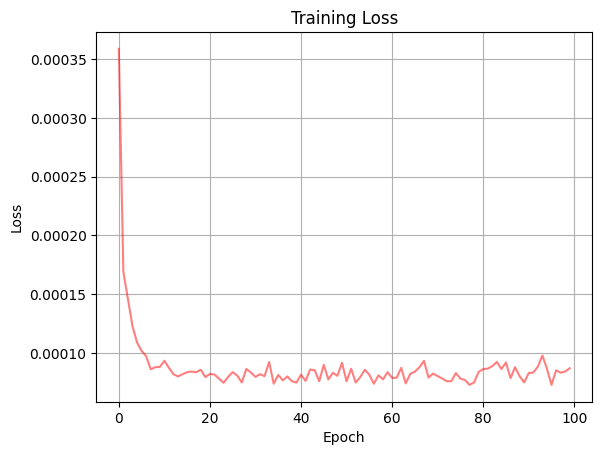

In [15]:
losses = []
model_2.train()

# Training loop
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        networks = torch.zeros((X_batch.shape[0], N-1)).to(device)
        for i in range(N-1):
            temp= model_2(t[i], X_batch[:, i].unsqueeze(1)).view(-1)
            networks[:, i] = temp
        
        pred = torch.zeros(y_batch.shape).to(device)
        delta_S = X_batch[:, 1:N] - X_batch[:, 0:N-1] 
        
        pred = torch.sum(networks * delta_S, dim=1)
        temp = BS_price(X_batch[:, 0], 0, 1, 30/365, 0.5, 0).to(device)
        pred += temp

        # Compute the loss
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()     

    training_loop.set_postfix(loss = loss.item())
    scheduler.step(loss)
    losses.append(loss.item())

plt.plot(losses, label='Training loss', color='red', alpha=0.5)
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model evaluation

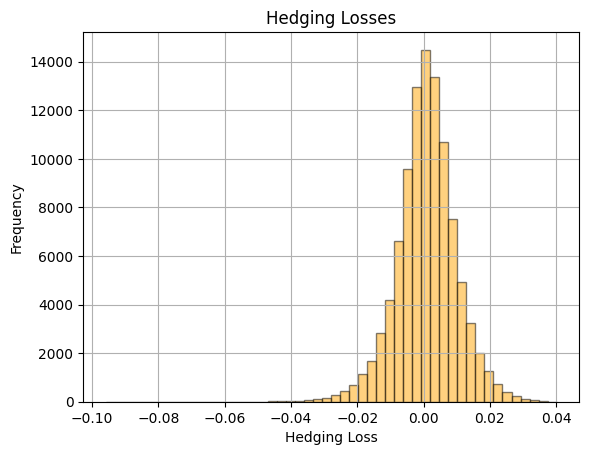

Mean Hedging Loss: 0.0009446139328368008
Standard Deviation of Hedging Loss: 0.00897681348350418


In [16]:
X_test = torch.tensor(S_test, dtype=torch.float32).to(device)
y_test = payoff(X_test[:, -1],K).to(device)
test_dataset = TensorDataset(X_test, y_test)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
hedging_losses_2 = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        networks = torch.zeros((X_batch.shape[0], N-1)).to(device)
        for i in range(N-1):
            temp= model_2(t[i], X_batch[:, i].unsqueeze(1)).view(-1)
            networks[:, i] = temp
        delta_S = X_batch[:, 1:N] - X_batch[:, 0:N-1]
        pred = torch.sum(networks * delta_S, dim=1)
        temp = BS_price(X_batch[:, 0], 0, 1, 30/365, 0.5, 0).to(device)
        pred += temp
        loss = pred-y_batch
        hedging_losses_2.append(loss.item())
        
# Plot a histogram of the hedging losses and print mean and standard deviation
hedging_losses_2 = np.array(hedging_losses_2)
plt.hist(hedging_losses_2, bins=50, alpha=0.5, label='Single Network Model', edgecolor='k', color= 'orange')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.title('Hedging Losses')
plt.grid(True)
plt.show()
mean_loss_2 = np.mean(hedging_losses_2)
std_loss_2 = np.std(hedging_losses_2)
print(f'Mean Hedging Loss: {mean_loss_2}')
print(f'Standard Deviation of Hedging Loss: {std_loss_2}')

## Comparison of the two Models

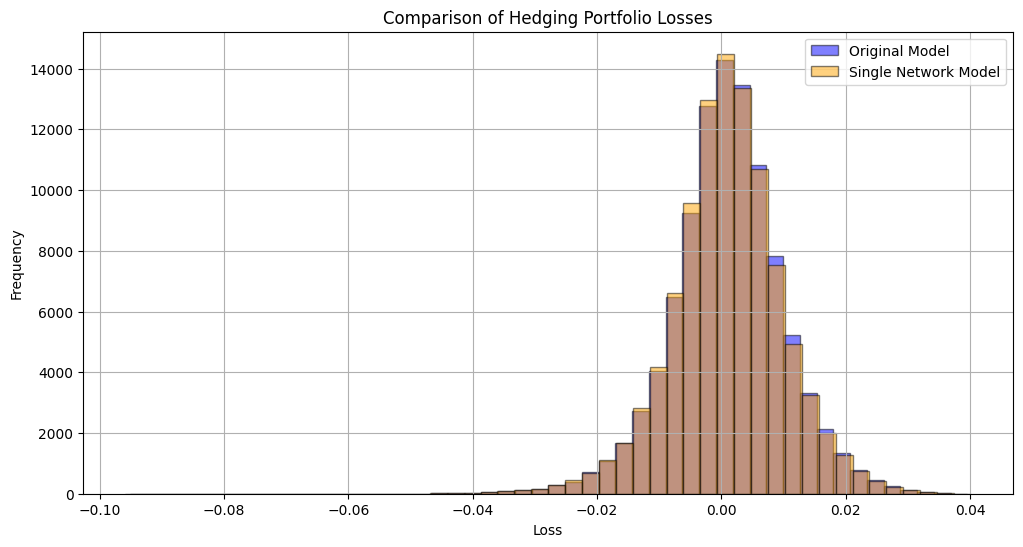

Original Model Hedging Losses: Mean = 0.000945, Std Dev = 0.008963
Single Network Model Hedging Losses: Mean = 0.000945, Std Dev = 0.008977
Total Parameters in Original Model: 64989
Total Parameters in Single Network Model: 1185


In [17]:
plt.figure(figsize=(12, 6))

# Histogram for Original Deep Hedging Model (Exercise 1)
plt.hist(hedging_losses, bins=50, alpha=0.5, label='Original Model', edgecolor='k', color='blue')

# Histogram for Single Network Model (Exercise 3)
plt.hist(hedging_losses_2, bins=50, alpha=0.5, label='Single Network Model', edgecolor='k', color= 'orange')

plt.title('Comparison of Hedging Portfolio Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Print empirical means and standard deviations
print(f"Original Model Hedging Losses: Mean = {mean_loss:.6f}, Std Dev = {std_loss:.6f}")
print(f"Single Network Model Hedging Losses: Mean = {mean_loss_2:.6f}, Std Dev = {std_loss_2:.6f}")

# Compare the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_original = count_parameters(model)
params_single = count_parameters(model_2)

print(f"Total Parameters in Original Model: {params_original}")
print(f"Total Parameters in Single Network Model: {params_single}")

## Conclusion

One can see that the performance of the two nets is close to identical even though the second approach uses only a fraction of the paramaters and is hence more efficient.
